<a href="https://colab.research.google.com/github/truongfaith/oscon-workshop/blob/master/Algo_backtesting_zipline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT MODULES

In [0]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import requests
import json

# PROCESS TRADING DATA

In [0]:
response = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=demo")
alphadict = json.loads(response.text)
stock = pd.DataFrame(alphadict['Time Series (Daily)']).T
stock.index = pd.to_datetime(stock.index)
stock.columns = ['open', 'high', 'low', 'close', 'volume']
stock = stock.astype(float)
stock = stock.sort_index(ascending = True)
stock.head()

,open,high,low,close,volume
2019-02-07,105.185,105.59,104.2900,105.27,29760697.0
2019-02-08,104.390,105.78,104.2603,105.67,21461093.0
2019-02-11,106.200,106.58,104.9650,105.25,18914123.0
2019-02-12,106.140,107.14,105.4800,106.89,25056595.0
2019-02-13,107.500,107.78,106.7100,106.81,18394869.0


# GENERATE TRADING SIGNAL

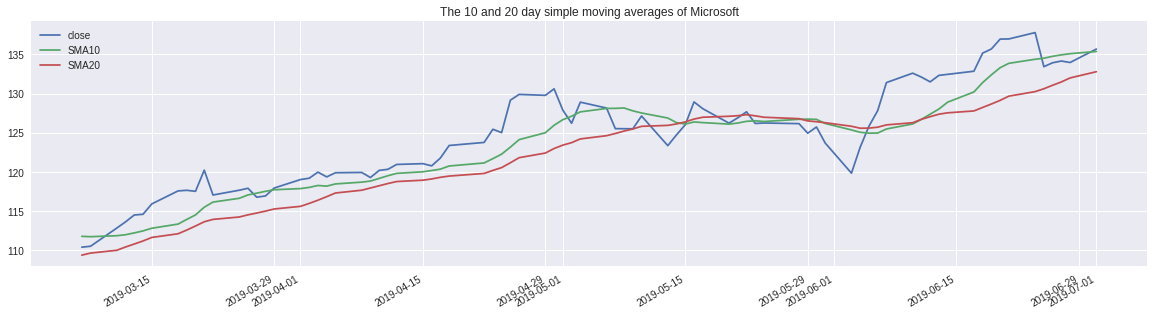

In [0]:
stock['SMA10'] = stock['close'].rolling(10).mean()
stock['SMA20'] = stock['close'].rolling(20).mean()
stock.dropna(inplace=True)
stock[['close','SMA10', 'SMA20']].plot(figsize=(20,5), grid = True, title='The 10 and 20 day simple moving averages of Microsoft'), plt.show();

# VECTORIZED BACKTESTING

In [0]:
stock['position'] = np.where(stock['SMA10'] > stock['SMA20'], 1, -1)
stock['returns'] = np.log(stock['close']/stock['close'].shift(1))
stock['strategy'] = stock['position'].shift(1) * stock['returns']
stock.dropna(inplace=True)
stock.head()

,open,high,low,close,volume,SMA10,SMA20,position,returns,strategy
2019-03-08,109.16,110.71,108.8000,110.51,22818430.0,111.729,109.6365,1,0.001086,0.001086
2019-03-11,110.99,112.95,110.9800,112.83,26491618.0,111.853,109.9945,1,0.020776,0.020776
2019-03-12,112.82,113.99,112.6499,113.62,26132717.0,111.979,110.4130,1,0.006977,0.006977
2019-03-13,114.13,115.00,113.7800,114.50,35513771.0,112.212,110.7935,1,0.007715,0.007715
2019-03-14,114.54,115.20,114.3300,114.59,30763367.0,112.468,111.1825,1,0.000786,0.000786


# EVALUATE PERFORMANCE

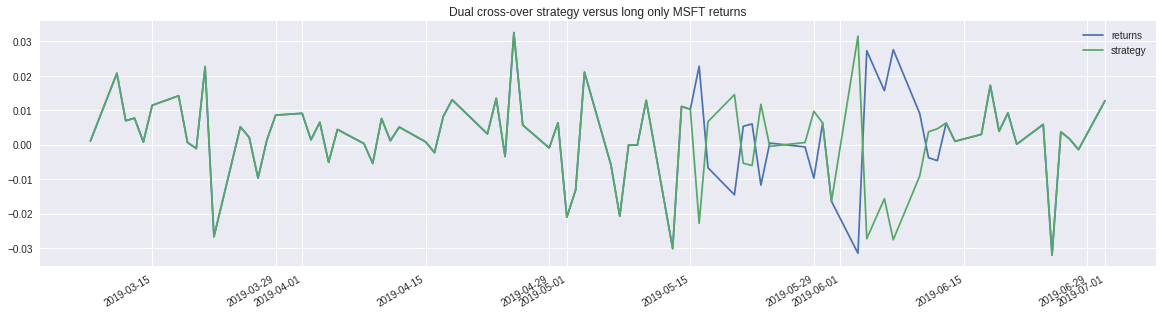

In [0]:
stock[['returns', 'strategy']].plot(figsize=(20,5), grid = True, title='Dual cross-over strategy versus long only MSFT returns'), plt.show();

In [0]:
np.exp(stock[['returns', 'strategy']].sum())

returns     1.229097
strategy    1.106307
dtype: float64

In [0]:
np.exp(stock['returns'])
stock[['returns', 'strategy']].describe()


,returns,strategy
count,80.000000,80.000000
mean,0.002578,0.001263
std,0.012773,0.012972
min,-0.032081,-0.032081
25%,-0.001642,-0.002595
50%,0.003086,0.002569
75%,0.009097,0.008335
max,0.032581,0.032581


#INSTALL ZIPLINE

In [0]:
!pip install zipline

# BACKTEST TRADING ALGORITHM

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from zipline.api import record, symbol, order_target
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.data import bundles
bundles.ingest ('quantopian-quandl')
from datetime import datetime
import pytz

def initialize(context):
  context.asset = symbol('AMZN')
  context.set_commission(commission.PerShare(cost=.002, min_trade_cost=1.0))
  context.set_slippage(slippage.VolumeShareSlippage())
  

def handle_data(context, data):
  
  short_sma = data.history(context.asset, 'close', 20, '1d').mean()
  long_sma = data.history(context.asset, 'close', 50, '1d').mean()
  
  
  record(asset=data.current(context.asset,'price'), short_sma=short_sma, long_sma = long_sma)
  
  if short_sma > long_sma:
    order_target(context.asset, 100)
    
  elif short_sma < long_sma:
    order_target(context.asset, 0)
  
capital_base = 100000
start = datetime(2015, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2018, 4, 1, 0, 0, 0, 0, pytz.utc)
perf = run_algorithm(start, end, initialize, capital_base, handle_data, bundle = 'quantopian-quandl')

#EVALUATE PERFORMANCE

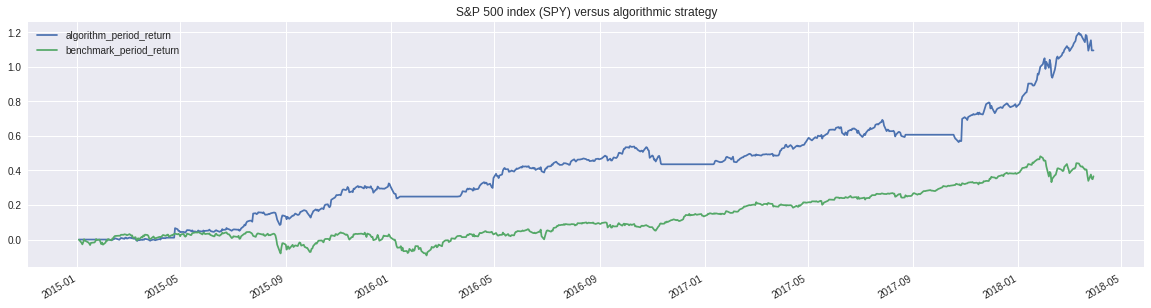

In [0]:
perf[['algorithm_period_return', 'benchmark_period_return']].plot(figsize=(20,5), title='S&P 500 index (SPY) versus algorithmic strategy'), plt.show();
  

In [0]:
perf.tail().T

,2019-03-26 20:00:00+00:00,2019-03-27 20:00:00+00:00,2019-03-28 20:00:00+00:00,2019-03-29 20:00:00+00:00,2019-04-01 20:00:00+00:00
algo_volatility,0.110792,0.11074,0.110689,0.110637,0.110586
algorithm_period_return,1.0945,1.0945,1.0945,1.0945,1.0945
alpha,0.147677,0.147948,0.147527,0.146926,0.14595
asset,NaN,NaN,NaN,NaN,NaN
benchmark_period_return,0.487691,0.479912,0.485521,0.494888,0.512616
benchmark_volatility,0.13645,0.136413,0.136359,0.136325,0.136375
beta,0.324474,0.324394,0.324316,0.324119,0.323476
capital_used,0,0,0,0,0
ending_cash,209450,209450,209450,209450,209450
ending_exposure,0,0,0,0,0


In [0]:
perf[['algorithm_period_return', 'benchmark_period_return']].tail()

,algorithm_period_return,benchmark_period_return
2018-03-23 20:00:00+00:00,0.82824,0.323284
2018-03-26 20:00:00+00:00,0.88854,0.359488
2018-03-27 20:00:00+00:00,0.82973,0.336361
2018-03-28 20:00:00+00:00,0.82973,0.332412
2018-03-29 20:00:00+00:00,0.82973,0.349437


# ZIPLINE DOCUMENTATION

https://www.zipline.io